In [1]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

saveFigs = False



from GetCoreData_fct import GetCoreData

import sys 
import os
sys.path.append('../')

from BackDiffuse_LT import BackDiffuse


from Interpolation_Class import Interpolation

from HL_AnalyticThea_class import HL_Thea
from DiffusionProfiles_calculations import DiffusionLength
from transforms import transforms
from Decon import SpectralDecon
from sigmaSolver import sigma_Solver

from SignalAttenuation import Attenuation

In [223]:
site = 'SiteA'
N_InInt = 33

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']
accum0 = CoreSpecs['Accum0']
accumIE = CoreSpecs['Accum1']
Temp0 = CoreSpecs['T0']

DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth = data_d18O['depth']
d18O = data_d18O['d18O']

depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']


In [224]:
accum0

0.281519

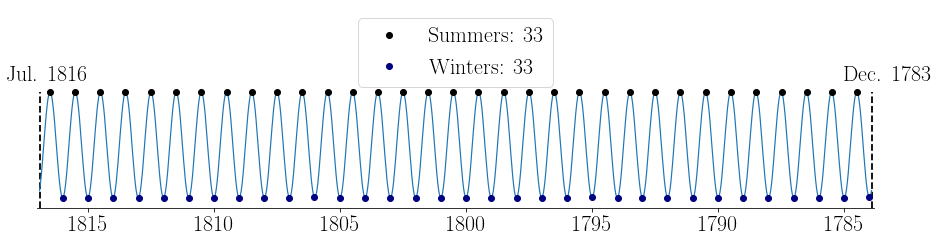

In [225]:
x = 1784 - 1/12 + np.linspace(0,33,1000)

l = 1
m = 6
p = (2*np.pi*m/12)
y = np.cos((2*np.pi*x - p)/l)


fig, ax = plt.subplots(figsize=(15,3.7), frameon=False)

ax.plot(x,y,lw=1.2)
ax.set(xlim=(min(x)-0.1,max(x)+0.1), ylim=(-1.2,2.6))

from scipy import signal

ps = signal.find_peaks(y)[0]
ts = signal.find_peaks(-y)[0]

ax.plot(x[ps], y[ps],'o', c='k', label=f'Summers: {len(ps)}')
ax.plot(x[ts], y[ts],'o',c='navy', label=f'Winters: {len(ts)}')
ax.invert_xaxis()
ax.axes.yaxis.set_visible(False)
ax.text(1818.2,1.2,'Jul. 1816', fontsize=22)
ax.text(1785,1.2,'Dec. 1783', fontsize=22)
#ax.axes.xaxis.set_ticklabels([])
ax.vlines(min(x),-1.2,1, lw=1.8, ls='--', color='k')
ax.vlines(max(x),-1.2,1, lw=1.8, ls='--', color='k')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.legend(fontsize=22, loc='upper center')

fig.savefig('../WrittenWork/Figures/summersWinters_LT.png', bbox_inches='tight')

In [226]:
from SignalAttenuation import AnnualLayerThick

In [227]:
depthALT = np.asarray(depth)
d18OALT = np.asarray(d18O)

inst = AnnualLayerThick(depthALT, d18OALT, 5)
fksMax, ls, lMean, lStd, vals = inst.ALT_fullCore()
vals_use = vals[:-1]

In [228]:

l_LT = np.mean(lMean[(vals_use > dTamb) & (vals_use < dLaki)])

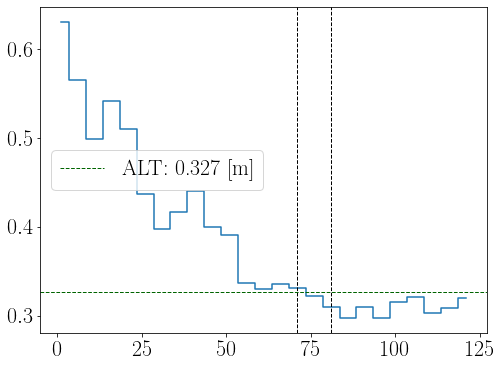

In [229]:
fig, ax = plt.subplots(figsize=(8,6))
ax.step(vals[:-1], lMean, where='mid')
ax.axvline(dTamb, c='k', ls='--',lw=1)
ax.axvline(dLaki, c='k', ls='--',lw=1)
ax.axhline(l_LT, c='darkgreen', lw=1, ls='--', label=f'ALT: {l_LT:.3f} [m]')
ax.legend()

In [230]:
ALT = l_LT
yrs = min(depth_LT) + ALT * np.arange(0,34)

pALT = ALT * len(depth_LT)/(max(depth_LT)-min(depth_LT))

dist = np.floor(pALT*(2/4))

peaks, props = signal.find_peaks(d18O_LT, distance = dist)
peaks2, props2 = signal.find_peaks(-d18O_LT, distance=dist)

[(-39, -29), (70.82000000000001, 80.937)]

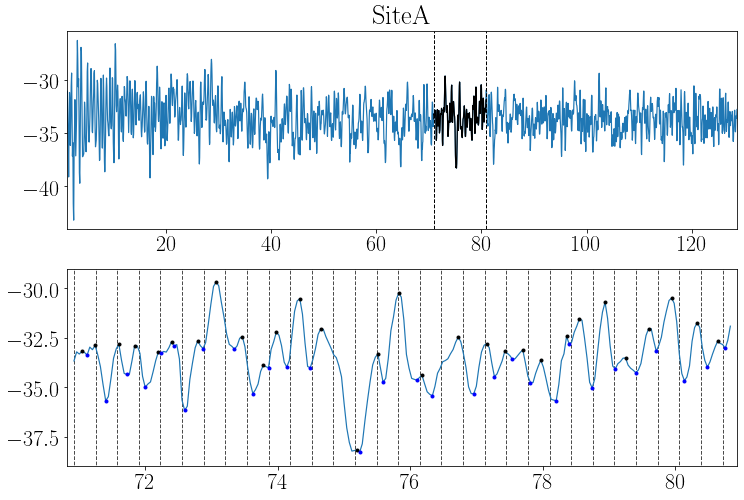

In [231]:
fig, ax = plt.subplots(2,1,figsize=(12,8))
ax[0].plot(depth,d18O, lw=1.2)
ax[0].plot(depth_LT,d18O_LT,c='k', lw=1.2)
ax[0].set(xlim=(min(depth), max(depth)), title=site)
ax[0].axvline(min(depth_LT), c='k', lw=1, ls='--')
ax[0].axvline(max(depth_LT), c='k', lw=1, ls='--')


ax[1].plot(depth_LT,d18O_LT, lw=1.2)


ax[1].plot(np.asarray(depth_LT)[peaks],np.asarray(d18O_LT)[peaks],'.', c='k')
ax[1].plot(np.asarray(depth_LT)[peaks2],np.asarray(d18O_LT)[peaks2],'.', c='b')
ax[1].vlines(yrs, -40, -25, lw=1, ls='--', alpha = 0.7)
ax[1].set(xlim=(min(depth_LT)-0.1, max(depth_LT)+0.1), ylim=(-39,-29))

In [232]:
depthN = np.asarray(depth_LT)
d18ON = np.asarray(d18O_LT)

depthN[peaks]

array([71.04 , 71.239, 71.598, 71.837, 72.195, 72.394, 72.79 , 73.068,
       73.464, 73.78 , 73.977, 74.332, 74.647, 75.198, 75.512, 75.826,
       76.178, 76.726, 77.155, 77.428, 77.701, 77.973, 78.362, 78.556,
       78.944, 79.254, 79.602, 79.95 , 80.336, 80.644])

In [233]:
depthN[peaks2]

array([71.119, 71.399, 71.717, 71.996, 72.235, 72.433, 72.592, 72.87 ,
       73.345, 73.622, 73.859, 74.135, 74.49 , 75.237, 75.59 , 76.1  ,
       76.335, 76.96 , 77.272, 77.545, 77.817, 78.206, 78.4  , 78.75 ,
       79.099, 79.408, 79.718, 80.143, 80.49 , 80.76 ])

In [234]:
inst = BackDiffuse(site, data_d18O, CoresSpecs, dTamb, dLaki, 33, diffLenData=data_diff_LT, densData=data_dens_LT)

In [235]:
depthEst, dataEst, diffLenFin, idxPeak, arr_diffLens, arr_Npeaks, arr_depth, arr_data = inst.backDiffused(print_Npeaks=False, interpAfterDecon=True)

Sigma fit: 7.05
Min sigma analyt: 7.69
Starting sigma: 5.05 [cm]
Final sigma: 5.40 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.019


In [244]:
peaksBD = sp.signal.find_peaks(dataEst)[0]
troughsBD = sp.signal.find_peaks(-dataEst)[0]

peaksBD_lst = np.ones(len(peaksBD))#['P'] * len(peaksBD)
troughsBD_lst = np.zeros(len(troughsBD))#['T'] * len(troughsBD)


exts = np.concatenate((peaksBD,troughsBD))
exts_lst = np.concatenate((peaksBD_lst,troughsBD_lst))
list1, list2 = (np.array(t) for t in zip(*sorted(zip(exts, exts_lst))))



if len(list1)%2 != 0:
    if list2[0] == 1:
        listNew_lst = np.append(list2,-1)
        listNew = np.append(list1,0)
    elif list2[0] == 0:
        listNew_lst = np.insert(list2,0,-1)
        listNew = np.inster(list1,0,0)
else:
    listNew_lst = list2
    listNew = list1
    


PTs = listNew_lst.reshape((int(len(listNew_lst)/2)),2)
PTs_idx = listNew.reshape((int(len(listNew)/2)),2)

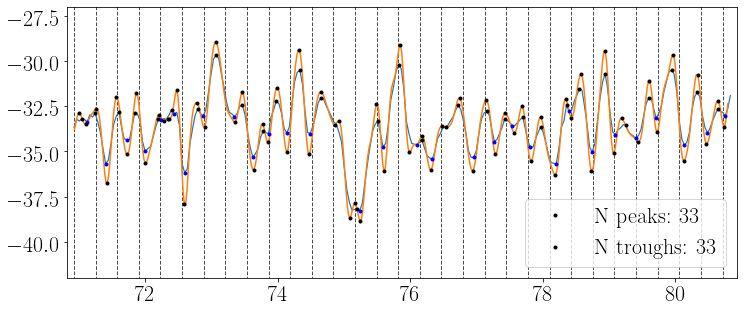

In [246]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(depth_LT,d18O_LT, lw=1.2)
ax.plot(depthEst, dataEst+np.mean(d18O_LT))

ax.plot(np.asarray(depth_LT)[peaks],np.asarray(d18O_LT)[peaks],'.', c='k')
ax.plot(np.asarray(depth_LT)[peaks2],np.asarray(d18O_LT)[peaks2],'.', c='b')
ax.plot(depthEst[peaksBD], dataEst[peaksBD]+np.mean(d18O_LT), '.', c='k',label=f'N peaks: {len(peaksBD)}')
ax.plot(depthEst[troughsBD], dataEst[troughsBD]+np.mean(d18O_LT), '.', c='k',label=f'N troughs: {len(troughsBD)}')
ax.vlines(yrs, -45, -25, lw=1, ls='--', alpha = 0.7)
ax.set(xlim=(min(depth_LT)-0.1, max(depth_LT)+0.1), ylim=(-42,-27))
ax.legend()

In [247]:
PTs

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [248]:
PTs_idx

array([[  4,   9],
       [ 17,  26],
       [ 33,  42],
       [ 49,  56],
       [ 67,  71],
       [ 74,  75],
       [ 81,  87],
       [ 97, 103],
       [112, 127],
       [133, 142],
       [149, 153],
       [160, 168],
       [178, 186],
       [195, 206],
       [209, 218],
       [222, 226],
       [239, 245],
       [258, 265],
       [275, 282],
       [291, 294],
       [305, 315],
       [326, 333],
       [341, 348],
       [354, 361],
       [369, 380],
       [389, 393],
       [401, 409],
       [420, 427],
       [433, 446],
       [455, 461],
       [474, 482],
       [493, 500],
       [509, 514]])

In [16]:
#peaksBD

array([  8,  24,  44,  58,  76,  90, 107, 124, 145, 166, 181, 198, 220,
       236, 247, 267, 285, 303, 317, 332, 355, 369, 384, 400, 419, 435,
       453, 465, 481, 496, 516, 532, 553])

In [37]:
#troughsBD

array([ 15,  33,  51,  65,  81,  99, 113, 132, 155, 174, 188, 206, 227,
       243, 252, 274, 294, 310, 324, 340, 363, 375, 392, 408, 425, 443,
       460, 472, 489, 502, 524, 541])